## Demonstration of Catastrophic Forgetting in Single Head Continual Learning

Current machine learning algorithms although perfom well on the task their are trained to do.If the trained model is fine-tuned on another dataset it starts to loose performence on older datasets. This is called **Catastrophic Forgetting**

Catastrophic Forgetting or Catastrophic interference is the tendency of neural network to completely and abruptly forget previously learned information upon learning new information.

By the usage of Rehersal/Replay, catastrophic forgetting can be avoided to a resonable extent.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [3]:
from continualai.colab.scripts import mnist
mnist.init() # We use MNIST Dataset

Files already downloaded!
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:

x_train, t_train, x_test, t_test = mnist.load() # MNIST Data is loaded

print(f'Size of training data is: {t_train.shape[0]}, size of test data: {t_test.shape[0]}')

for i in range(10):
  print(f'Size of label {i} in training : {len(t_train[t_train == i])}')

Size of training data is: 60000, size of test data: 10000
Size of label 0 in training : 5923
Size of label 1 in training : 6742
Size of label 2 in training : 5958
Size of label 3 in training : 6131
Size of label 4 in training : 5842
Size of label 5 in training : 5421
Size of label 6 in training : 5918
Size of label 7 in training : 6265
Size of label 8 in training : 5851
Size of label 9 in training : 5949


Under Single head setting we can use all 10 classes. But for Multi head setting we need to group the 10 classes into 5 takss by grouping them together.We call this task_data_with_overlap since the classes overlap.

In [35]:

task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)] #Tasks
tasks_num = len(task_classes_arr) # 5

task_data = []
task_data_with_overlap = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))
  task_data_with_overlap.append((x_train_task, t_train_task - (i * 2),
                                 x_test_task, t_test_task - (i * 2)))


def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")

    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])



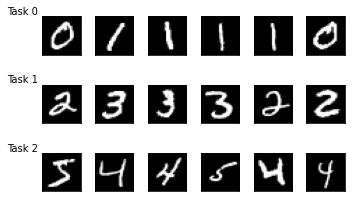

In [36]:
n_tasks, samples = 3, 6
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 3))
for task in range(0,3):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

**Naive Model with Single Head strategy**

The Naive strategy simply finetunes the model on the new data, without applying any CL strategies.

In [13]:
class FNet(nn.Module):
  def __init__(self, hsize=512):
    super(FNet, self).__init__()

    self.l1 = nn.Linear(784, hsize) #Pytorch Linear
    self.l2 = nn.Linear(hsize, 10)
    
  def forward(self, x):
      x = x.view(x.size(0), -1)
      x = F.relu(self.l1(x))
      x = self.l2(x)
      return x

In [31]:
def train(model, device, x_train, t_train, optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [32]:
def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    return test_loss, 100. * correct / len(t_test)

In [19]:
model = FNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
x_train_1, t_train_1, x_test_1, t_test_1 = task_data[0]
x_train_2, t_train_2, x_test_2, t_test_2 = task_data[1]
x_train_3, t_train_3, x_test_3, t_test_3 = task_data[3]

print('Training on Task 1')
train(model, device, x_train_1, t_train_1, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')

print('------------')
print('Training on Task 2')
train(model, device, x_train_2, t_train_2, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')
loss, acc = test(model, device, x_test_2, t_test_2)
print(f'Testing on Task 2: loss -> {loss}, acc -> {acc}')

print('------------')
print('Training on Task 3')
train(model, device, x_train_3, t_train_3, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')
loss, acc = test(model, device, x_test_2, t_test_2)
print(f'Testing on Task 2: loss -> {loss}, acc -> {acc}')
loss, acc = test(model, device, x_test_3, t_test_3)
print(f'Testing on Task 2: loss -> {loss}, acc -> {acc}')

Training on Task 1
Testing on Task 1: loss -> 1.564920339381089e-05, acc -> 99.95271867612293
------------
Training on Task 2
Testing on Task 1: loss -> 0.0661305069077945, acc -> 0.0
Testing on Task 2: loss -> 0.0002987998465658051, acc -> 97.20861900097943
------------
Training on Task 3
Testing on Task 1: loss -> 0.05382058524634539, acc -> 0.0
Testing on Task 2: loss -> 0.06662563899355001, acc -> 0.0
Testing on Task 2: loss -> 7.496255884661686e-05, acc -> 99.24471299093656


As we can see, the progress we achieved on Task #1 is lost once we fine-tune to Task #2. This is because of Catastrophic Forgetting seen in Neural Networks

**Continual Learning via Rehearsal / Replay:**

One way to mitigate Catastrophic Forgetting is to keep a portion of the old data to be interleaved with the data from the current task, so that the network does not forget. An ideal scenario is to keep all the old data, however, this is not practical in real applications with memory constraints. Therefore, it is preferrable to keep a limited number of old patterns to be replayed.


In [24]:
def siu(dataset, seed, in_place=False):


    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_data.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_data


In [25]:
def train_singlehead(past_examples_percentage=0, epochs=15):
  model = FNet().to(device) 
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  accs_fine_grid = []
  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data[i] #Iterate through all 5 Tasks

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = siu([x_train, t_train], 0) #Data Shuffled
    train(model, device, x_train, t_train, optimizer, epochs)

    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data[j]
      _, test_acc = test(model, device, x_test, t_test)
      accs_subset.append(test_acc)
    
    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))

    accs_fine_grid.append(accs_subset)

  return accs_fine_grid


In [26]:
accs_naive = train_singlehead() # naive: 0%
accs_rehearsal_all = train_singlehead(1) # regural supervised fashion: 100% 
accs_rehearsal_5 = train_singlehead(0.05) # 5%, about 100 example per task

In [27]:
accs_naive

[[99.95271867612293, nan, nan, nan, nan],
 [0.0, 98.13907933398629, nan, nan, nan],
 [0.0, 0.0, 99.46638207043756, nan, nan],
 [0.0, 0.0, 0.0, 99.59718026183283, nan],
 [0.0, 0.0, 0.0, 0.0, 98.18456883509833]]

In [28]:
accs_rehearsal_all

[[99.95271867612293, nan, nan, nan, nan],
 [99.29078014184397, 98.4818805093046, nan, nan, nan],
 [99.24349881796691, 97.89422135161607, 98.93276414087514, nan, nan],
 [99.10165484633569,
  97.74730656219393,
  98.3991462113127,
  98.03625377643505,
  nan],
 [99.05437352245863,
  98.13907933398629,
  97.49199573105656,
  97.18026183282981,
  96.92385274836107]]

In [29]:
accs_rehearsal_5

[[99.95271867612293, nan, nan, nan, nan],
 [93.94799054373523, 98.28599412340843, nan, nan, nan],
 [95.0354609929078, 84.32908912830558, 99.62646744930629, nan, nan],
 [95.65011820330969,
  86.87561214495592,
  87.45997865528281,
  98.7411883182276,
  nan],
 [94.13711583924349,
  81.83153770812929,
  78.97545357524012,
  85.2467270896274,
  97.78113968734242]]

Text(0.5, 24.0, 'Task Number')

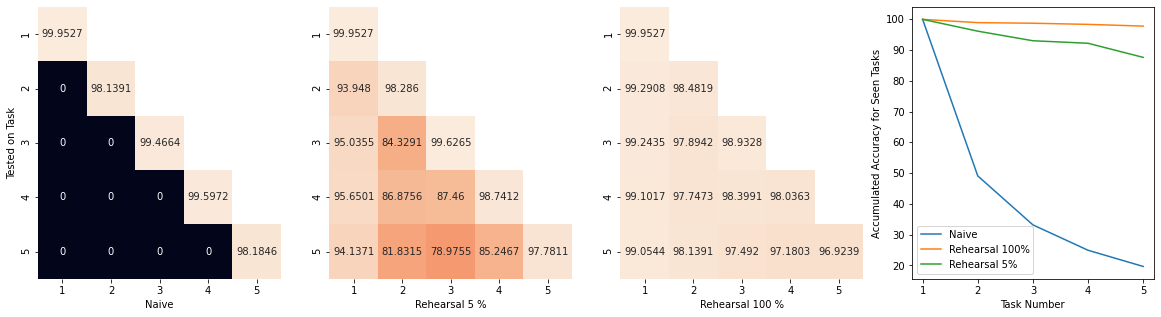

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive') # No Rehersal
axes[1].set_xlabel('Rehearsal 5 %')
axes[2].set_xlabel('Rehearsal 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))
axes[3].legend(['Naive', 'Rehearsal 100%', 'Rehearsal 5%'])
axes[3].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')

In the above graph, we saw that accuracy improves by adding 5% of previous data (~50 example per class). Even if forgetting is not completely defeated, it definitely is a step forward from the Naive strategy.